AI Jump-up 교육은 실습위주 교육이라고 들어서 실습을 중간중간 실습할 수 있도록
강의를 준비하게 되었고, 그래서 발표자료와 실습을 왔다갔다하는 문제를 방지하기 위해
MD로 자료를 만들게 되었습니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import matplotlib.pyplot as plt
from IPython.display import HTML

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

def plot_loss_variation(result, **kwargs):

    '''
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    '''
    list_data = []
    for epoch, train_loss in enumerate(result['train_losses']):
        list_data.append({'type': 'train', 'loss': train_loss, 'epoch': epoch})
    for epoch, val_loss in enumerate(result['val_losses']):
        list_data.append({'type': 'val', 'loss': val_loss, 'epoch': epoch})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(result, **kwargs):
    list_data = []
    for epoch, train_acc in enumerate(result['train_accs']):
        list_data.append({'type': 'train', 'Acc': train_acc, 'test_acc': result['test_acc'], 'epoch': epoch})
    for epoch, val_acc in enumerate(result['val_accs']):
        list_data.append({'type': 'val', 'Acc': val_acc, 'test_acc': result['test_acc'], 'epoch': epoch})


    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric, horizontalalignment='left', verticalalignment='center',
                 transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=0)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc


def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=0)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc


def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=0)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc


def experiment(partition, args):
    if args.model == 'CNN':
        net = CNN()
    elif args.model == 'Resnet':
        net = Resnet()
    else:
        raise ValueError('In-valid model choice')
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            'Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch,
                                                                                                                  train_acc,
                                                                                                                  val_acc,
                                                                                                                  train_loss,
                                                                                                                  val_loss,
                                                                                                                  te - ts))

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('ready.')

Files already downloaded and verified
Files already downloaded and verified
ready.


## 3. **Deep Learning for Computer Vision**
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture01.pdf_page_10.png?raw=true)
### 3.1  Plan for this lecture
1. d
2. d
3. d


    이제 컴퓨터비젼에서 활용되는 딥러닝 기술들을 봅시다.
    컴퓨터 비젼에 활용되는 현재 딥러닝 핵심 네트워크는 Convolutional Nerual Network입니다.
    Covolutional Neural Network는 CNN, ConvNet이라고 대부분 줄여서 부르고 있습니다.
***

### 3.2 Introduction
![pt](https://github.com/karaopea/cnn/blob/master/images/lecture_1_feifei.pdf_page_06.png?raw=true)

    CNN의 등장은 컴퓨터비전의 다양한 부분에 영향을 줬습니다.
    객체검출.......VQA(시각적 질의응답)까지 전체적인 정확도 향상을 가져왔습니다.
***

### 3.2 What is Convolutional Neural Network?
#### 3.2.1 How human recognize an image?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide27.PNG?raw=true)

    Deep Learning을 강의에서 뉴런이 등장하듯이, CNN강의에서는 대부분 이 그림을 보실 수 있는데요,
    과연 인간의 뇌가 MLP처럼 단순하게 동작할까? 좀 더 우리가 모르는 것이 있지 않을까?
    사람이 이미지를 어떻게 인식하는지 생물학적(biologic)으로 알아보기 시작합니다.
    그래서  저런 단순한 움직임을 보여주며, 고양이의 뇌를 관찰합니다.
    선이 움직인다든지, 원이 커진다든지 이런 단순한 움직임을 보여줬는데.
    이런 움직임에서는 이 뉴런들만 활성화되고, 이런 움직임에서는 이런 뉴런들만 활성화되는것을
    발견할 수 있었습니다.
    그래서 우리는 이미지를 볼때 이런 간단한 특징들을 담당하는 뉴런들이 있는게 아닐까 그렇게 생각을 하게 됩니다.
***

### 3.2 What is Convolutional Neural Network?
#### 3.2.1 How human recognize an image?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide28.PNG?raw=true)

    그리고 더 연구를 해보니까, 이 뉴런들이 계층 구조를 이루고 있다는 것을 알게됬거든요?
    무작위하게 얽혀있는게 아니라, 시각세포와 연결되어 있는 이런 얕은(shallow)한 뉴런들이 있고
    그리고 뒤에 이런 딥한 뉴런들이 있었는데, 이런 뉴런들이 언제 활성화가 되는지 살펴보니까
    이런 얕은 얘들은 빛이 있냐 없냐, 어떻게 기울어져있냐 등 간단한 정보에 반응을하고
    깊어지면 깊어질수록 이 선이 움직이느냐, 선이 이어져있느냐 끝나느냐.
    깊어지면 깊어질수록 고차원적인 정보를 담당하는 것을 알아내게 됩니다.
    그럼 이것을 어떻게 수학적으로 모델링해서 NN으로 만들 수 있을까? 이걸 고민해볼 차례겠죠.
***

In [ ]:

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/FwFduRA_L6Q" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

    얀 르쿤 교수님 팀에서 lenet이라는 convolutional network를 발표합니다.
    hand-writting 문자를 성공적으로 인식하는 것을 보실 수 있습니다.
    convolution, pooling등을 이용하며 이미지를 어떻게 딥러닝에 학습시킬지 방법론을 정립합니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide31.PNG?raw=true)

    그렇다면 이미지를 어떻게 뉴럴넷에 넣을 수 있을까요?
    이런 이미지가 있다고 생각해봅시다.
    배경에 나무라는 객체가 있는 심플한 이미지 입니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide32.PNG?raw=true)

    이 이미지를 뉴럴넷에 입력으로 넣고 싶은데, 뉴럴넷은 입력으로 벡터를 받기 때문에
    이미지는 2디멘션 그리드의 픽셀들입니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide34.PNG?raw=true)

    이 뉴럴넷에 넣기 위해 이미지를 쭉펴서 벡터로 만듭니다.
    이제 이 쫙 핀 이미지를 뉴럴넷에 넣으면 되겠네요.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide35.PNG?raw=true)

    하지만 기대와는 다르게 이렇게 넣으면 안됩니다.
    첫번째 문제는 이미자안에서 나무가 조금만 이동하더라도 인풋에 대한 특징이 달라지게 되어
    전혀다른 결과물을 만들게 됩니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide36.PNG?raw=true)

    우리는 이 이미지안에서 객체가 어느위치에 있든 같은 객체라고 인식하길 원합니다.
    이것을 Translation invriance하다고 하며,
    의미있는 정보를 위치에 상관없이 추출하고 같은 결과를 출력하길 원합니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution ≈  Cross-correlation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide37.PNG?raw=true)

    여기서 이런 객체의 위치에 구애받지 않고, 지역적 특징을 잘 추출하기 위해서
    Convolution 연산을 사용합니다.
    이해를 돕기 위해서 이미지를 1차원으로 줄였다고 가정하고 설명하겠습니다.
    Convolution 연산의 수학적 의미는 왼쪽과 같고,
    쉽게 커널(필터)를 뒤집고 곱해서 더한다라고 생각하시면됩니다.
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide38.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide39.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide40.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide41.PNG?raw=true)

    인풋 시그널이 어디에 있든 result의 위치는 다르겠지만 같은 형태의 결과가 나올 것입니다.
    이렇게 convolution연산과 softmax를 통해서 Translation invriance한 결과를 만듭니다.
    실제 뉴럴넷에서는 커널을 뒤집는것이 중요하지 않기 때문에, 커널을 그냥 곱해주는
    cross-correlation연산을 하지만 개념적인 부분만 사용한 것이기 때문에 Convolution이라고 부릅니다.
    그래서 딥러닝에서는 아래 result를 가지고 우리가 원하는 정답값과 비교를 해가면서 차이를 줄이는 방향으로
    위에 kernel형태를 학습을 반복하면서 변경해 나갑니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/sobel.png?raw=true)

    이건 sobel 필터라는 건데요 sobel이란 사람이 이미지의 외곽선 검출을 위해 kernel(필터)를 이렇게 정의를 한겁니다.
***

In [ ]:
# haar like
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/hPCTwxF0qf4" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


    마찬가지로 이건 Viola, Jones가 정의한 haar-like feature인데요,
    얼굴에 대한 특징을 여러개의 필터 이용해서 찾는 것을 보실 수 있습니다.
    딥러닝에서는 어떻게 하면 목표 객체의 특징을 잘 찾을 수 있는 커널을 컴퓨터가 찾아주는 것이죠

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide43.PNG?raw=true)

    그럼 다시 2차원 이미지로 돌아와봅시다.
    1차원때 설명한 것과 같은 방법으로 진행합니다.
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide44.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide45.PNG?raw=true)

    한칸씩 이동하면서 곱하고 더해서 값을 만들고, 오른쪽 끝에 도달하면 한칸 아래로 내려와서
    반복합니다. 이것을 이미지 끝까지 진행하면 오른쪽과 같은 2차원 결과가 만들어질 것입니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide46.PNG?raw=true)

    우리는 3x3의 슬라이딩 윈도우를 커널이라고 부르고,
    이 커널과 곱하고 합해져서 나온 값을 feature map이라고 부릅니다.
    그리고 이 feature map을 보시면
    왼쪽 위 한칸이 상위의 3x3의 정보가 들어온것이기 때문에,
    이 칸의 Receptive filed는 여기 3x3이다 라고 말합니다.

***

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide47.PNG?raw=true)

    이 3x3 convolution unit들은 뉴럴넷의 뉴런과 같은 기능을 하고 있으며,
    weight와 bias값을 가지고 이미지에서 선, 색상등 다양한 feature를 잘 추출하기 위해 학습되어 집니다.

    그럼 이미지를 하나 불러서 convolution 연산을 실습해봅시다.
***

In [ ]:
# select car image in cifar10 dataset
img = partition['train'].dataset.data[4]
plt.imshow(img)
plt.show()
print('1.image shape:',img.shape)

# trans np to torch (h,w,c) -> (c,h,w)
x = transform(img)
print('2.tensor shape:',x.shape)

conv = nn.Conv2d(3, 3, 3, stride=1)
# add batch dim
x = x.unsqueeze(0)
x = conv(x)
imshow(x.squeeze().detach().cpu())
print('3.shape of feature map after conv:',x.squeeze().shape)

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide52.PNG?raw=true)

    방금 실습에서는 3개의 커널을 사용해서 convolution연산을 했습니다.
    커널이 많아질수록 각 필터가 예를들어 가로, 세로, 대각선 특징들을 뽑듯이
    다양한 feature들을 추출할 수 있습니다.
***

In [ ]:
# select car image in cifar10 dataset
x = transform(img)
print(x.shape)

conv = nn.Conv2d(3, 3, 3, stride=1)
x = x.unsqueeze(0)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide55.PNG?raw=true)

    위 코드 처럼 convolution연산은 convolution을 거듭할 수록 다음 feature맵이 작아지게 됩니다.
    입력 이미지가 작을 경우에는 convolution 연산을 몇번 할 수 없겠죠?
    마찬가지로 입력이 계속 작아지니 네트워크도 깊게 쌓을 수 없을 것 입니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.3 Padding
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide57.PNG?raw=true)

    그래서 convolution 연산을 할 때, 테두리에 여분을 추가해서 입력이 축소되는 것을 방지합니다.
    이렇게 여분을 추가하는 것을 padding이라 부르고,
    input과 output크기가 같게 나오도록 conv하는 것을 same convolution이라고 부릅니다.
    3x3 커널일때는 한줄만 추가하면 되지만, 5x5 커널을 사용한다면 두줄을 추가해야 same conv가 되겠죠?
***

In [ ]:
# select car image in cifar10 dataset
x = transform(img)
print(x.shape)

conv = nn.Conv2d(3, 3, 3, stride=1, padding=1)
x = x.unsqueeze(0)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)

### 3.3 Convolutional Neural Network
#### 3.3.4 Pooling
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide59.PNG?raw=true)

    반대로 입력 이미지가 너무 클 경우를 생각해봅시다.
    입력이 크다는 것은 유지해야할 parameter가 많아진다는 것을 뜻하는 것이고,
    이는 모델이 너무 커져 학습속도도 느려지고 같은 파라미터값들이 많아지는 현상이 일어날 수 있습니다.
    그래서 우리는 어느정도 이 feature map크기에서 특징추출을 한것 같다라는 생각이들면
    pooling을 통해서 입력을 줄여줍니다. 보통 계산하기 편하기 위해 입력을 반으로 줄입니다.
***

In [ ]:
# select car image in cifar10 dataset
x = transform(img)
print(x.shape)

conv = nn.Conv2d(3, 3, 3, stride=1, padding=1)
x = x.unsqueeze(0)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)

### 3.3 Convolutional Neural Network
#### 3.3.5 Sequence of convolutional layers
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide61.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide63.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide64.PNG?raw=true)
    위와같이 CNN은 Convolution, Activation Fuction인 ReLU, Pooling등을 반복하면서 연산을 해나갑니다.
    첫번째 Convolution Kernel들은 색상이나 선의 방향등 단순한 feature들을 학습하고,
    Layer가 깊어질수록 더이상은 인간이 이해하지 못하는 고차원적인 feature들이 representation됩니다.RGB기 때문에..
    그래도 깊이 있는 애들이 복잡한 것을 탐지한다고 예상할 순 있겠네요.

    shallow한곳에서는 단순한 feature를 인식하고 deep한곳에서는 간단한 정보를 취합함으로써 좀 더 복잡한 정보를 탐지한다.
    이런식으로 뇌가 동작한다고 연구가 되어왔는데 그것을 잘 모방했다고 볼 수 있겠네요.

    이 그림은 언제 Layer5의 뉴런들이 Activation되는지 weight를 쌓아가면서 계산하여 Visulization을 한건데요,
    Layer 5까지오면 꽃잎의 형태, 사람얼굴, 강아지의 얼굴등 고차원적인 정보를 다루는 것을 볼 수 있습니다.
***

In [ ]:
# select car image in cifar10 dataset
img = partition['train'].dataset.data[4]
plt.imshow(img)
plt.show()

# trans np to torch (h,w,c) -> (c,h,w)

x = transform(img)

conv = nn.Conv2d(3, 3, 3, stride=1, padding=1)
relu = nn.ReLU()
pooling = nn.MaxPool2d(2,2)
# add batch dim
x = x.unsqueeze(0)
x = relu(conv(x))
imshow(x.squeeze().detach().cpu())
x = pooling(relu(conv(x)))
imshow(x.squeeze().detach().cpu())
x = relu(conv(x))
imshow(x.squeeze().detach().cpu())

    실습을 간단히 해보자면, 여기서는 커널(필터)들이 어떻게 학습되어지는진 볼 순 없지만
    Conv연산을 거칠수록 feature맵이 어떻게 변화되는지 살펴보도록 합시다.
    위에 설명드린것처럼 Convoltion연산을 하고, Activation function을 통과하고 중간에 풀링을 해보겠습니다.

### 3.3 Convolutional Neural Network
#### 3.3.5 Sequence of convolutional layers
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide65.PNG?raw=true)

    이것은 Convolution Net의 기본 구조를 나타낸건데요. 한번 봅시다.
    아까 말씀드렸듯이, Conv, ReLU, Pool을 반복하고, 마지막에 FC가 있네요.
    FC는 MLP와 같은 말입니다. 마지막에 나온 고차원적인 정보를 vectorize 시켜서
    MLP에 넣어주고, 이게 어떤 객체인지 MLP와 했던것과 똑같이 분류문제를 풉니다.
    마지막 feature맵은 더이상 위치정보가 남아있지 않은 객체의 feature의 정보이기 때문에
    MLP로 넣을 수 있게 되는거구요.

    그럼 위와 그림과 같은 ConvNet을 하나 구현해볼까요?
***

In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1 )
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1 )
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        #32->16->8->4 : 4*4*64
        self.fc = nn.Linear(4*4*64, 10)

    def forward(self, x):
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool(x)
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.pool(x)
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
#models = ['CNN', 'Resnet']
args.model = 'CNN'
args.act = 'relu'
args.l2 = 0.00001
args.optim = 'SGD'  # 'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 1e-3
args.epoch = 40

args.train_batch_size = 128
args.test_batch_size = 32


print(args)
setting, result = experiment(partition, deepcopy(args))
plot_loss_variation(result)
plot_acc_variation(result)

### 3.4 Going deeper: Case studies
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide74.PNG?raw=true)

    ImageNet 데이터 베이스를 이용해서 1000개의 클래스에 대한 top-5 error 그래프입니다.
    cifar에 비해서 이미지도 크고(227x227x3) 분류해야될 클래스도 많기 때문에 어렵겠죠? 데이터셋도 더 크구요.
    이 network들이 어떠한 테크닉을 사용하였는지, case study를 통해 같이 살펴보겠습니다.
***



### 3.4 Going deeper: Case studies
### 3.4.2 AlexNet
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide71.PNG?raw=true)

    CNN을 사용해서 Imagenet Challange에서 우승한 최초의 딥러닝 네트워크인 alexnet입니다.
    논문에도 아키텍쳐 다이어그램이 위에 짤린것으로 나타내는 데, 정확히는 모르겠지만 의도적으로 한것같다.
    이 아키텍처 다이그램이 보통적으로 보이지 않는 이유는 2gpu를 사용해서 큰 모델을 학습시키기 위해서,
    two-stream network입니다.
    학습하는데, 6일이 걸렸음, 지금은 몇분만에 학습가능
    alexnet의 특징은 처음으로 CNN을 제대로 사용할 수 있다고 말씀드릴 수 있겠는데요,
    첫번째는 vanishing Gradient 문제를  해결하기위해 ReLU를 사용했으며,
    overfitting을 피하기 위해 dropout, weight decay를 사용했습니다.
    weight decay는 특정한 weight값이 너무 크면 큰 만큼 값을 줄여줘서(부식시킨다) regularization해주는 겁니다.
    (신경망이 범용성을 갖도록 처리하는 거니까 regularization은 일반화 정도라고 생각하시면됩니다 normalization, 정규화와는 다른의미입니다.)
***

### 3.4 Going deeper: Case studies
### 3.4.2 AlexNet
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide72.PNG?raw=true)

    alexnet을 단순화 시켜보면 이렇습니다. input을 conv, non-linaer, pooing 반복반복,
    마지막에 fcfcfc, lenet, cnn의 기본구조와는 거의 차이가없죠? 그래서 이 친구 같은 경우는 아직 advanced cnn은 아니다.
    처음으로 convolution layer를 dnn에 잘 적용했기때문에 다뤄보았구요,
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/karaopea/cnn/blob/master/images/Lec6-A.pdf_page_17.png?raw=true)

    이제부터 중요해지는 그 다음것을 봅시다.
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide75.PNG?raw=true)

    VGGNet은 2014년도에 2위를 한 oxford대학의 네트워크입니다. 1위는 GoogLeNet이 했죠.
    이 네트워크를 다루는 이유는 VGGNet의 네트워크 디자인 룰이 간단하고 효과적이기 때문에 아직까지도 많은 영향을 미치고 있기 때문입니다.
    네트워크를 간단히 살펴보자면, conv,conv,pooling -> .... -> conv,conv,conv,conv,poopling,fcfcfc 구조네요.
    conv를 연속적으로 한다는 것 빼고는 딱히 alexnet과 큰 차이는 없지만, 우리는 Design rule을 볼 필요가 있습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture08.pdf_page_041.png?raw=true)

    첫번째 디자인 룰은 same convolution을 합니다. 위에서 한번 말씀드렸듯이 padding 1을 추가해서 feature map이 작아지는 것을
    방지하여 좀 더 깊은 네트워크를 만들 수 있게 합니다. 그리고 conv-pooling을 하는 이전과는 다르게 conv-conv-pooling을 하는
    구조를 보실 수 있으실텐데요, 우리는 가로세로 5칸의 window를 featuremap에 담고싶다고 하면,
    (이 윈도우를 receptive field라 위에서 말씀드렸죠?) 5x5 conv를 한번 하는것보다,
    3x3을 두번 하는 것이 효과적이다라는 것을 찾아내었기 때문인데요, 아래보시면
    파라미터 수와 실수연산은 더 적은데 같은효과 오히려 non-linearity를 두 번 적용한 더 좋은 결과가 나온다는 것을 보실 수 있습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide76.PNG?raw=true)
    두번째, 첫번째 레이어의 5x5 receptive filed를 보는 것과 같은 효과라는 것을 도식화 한 그림입니다.
    왜냐하면 첫번째 conv-layer를 통과한 fateure-map의 한 칸이 input 3x3 정보를 담고 있기 때문이죠.
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture08.pdf_page_044.png?raw=true)

    두번째 룰은 plooing을 할때, feature map을 반으로 줄이고 채널 수를 두배로 키워줍니다.
    이 룰은 아주 많은 cnn 아키텍쳐들이 따르고 있는 룰인데요,
    각 conv스테이지마다 메모리는 줄이고 실수 연산cost는 유지하고 싶었기 때문입니다.
    (Memory=H*W*C , Params=c_in*c_out*k_h*k_w, Params=(k_h*k_w*k_z)*filters_num, FLOPs=(c_out*h*w)*(c_in*k_h*k_w)
***


### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide77.PNG?raw=true)

    이 그래프는 VGG의 imagenet top-5 error인데요, 16레이어까지는 깊게 깧을 수록 에러가 낮아지는 것을 볼 수 있는데,
    더 깊게 쌓으면 에러가 차라리 높아지는 것을 볼 수 있습니다.
    깊어질수록 많아지는 연산량과 weight paramter들을 optimize를 하는 것이 어려움을 어떠한 네트워크 디자인을
    통해 극복했는지 살펴보도록 합시다.
***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: Inception module
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide92.PNG?raw=true)

    14년도 Imagenet challange(ILSVRC) 1위를 한 GooLeNet입니다. 2위는 VGG구요.
    GooLeNet에서 중간에 L자가 대문자인 이유는 얀르쿤교수팀이 개발한 Lenet을 shoutout하는 의미로 하였구요.
    네트워크 아키텍쳐가 조금 복잡해보이는데요, 가장 눈에 띄는점은 뭐 이렇게 묶음이 있구요, 중간중간 곁가지 처럼 나온게 있네요.
    이 묶음이랑 곁가지를 제외하고 본다면 일반적인 CNN구조와 유사하게 매우 단순한 구조로 가지고 있습니다.

    우선 옆으로 나온 곁가지에 대해 설명드리자면, 끝에서 나온 loss는 초반부 layer에 영향이 약해지는 vanishing gardient문제를
    조금이라도 보완하고자, 중간중간 loss도 뽑아서 역전파를 시키자는 trick입니다.
    15년도에 batch normalizaion이라는 학습 방법이 나온 뒤는 더이상 사용하지 않습니다.

    그럼 이 묶음은 뭘까요? 이 묶음에 대해서 자세히 알아보도록 합시다.

***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: Inception module
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide93.PNG?raw=true)

    이 묶음의 이름은 inception module이라고 합니다.
    영화 인셉션에서 "우리는 좀더 깊이 들어가야해."라는 대사가 나옵니다. 영화에선 꿈의 심연을 뜻하는거겠죠?
    딥러닝에서도 좀 더 깊이 네트워크를 쌓고자하는 바램에서 inception이란 이름을 따왔습니다.

    inception module을 크게 확하면 왼쪽과 같은데, parallel한 구조를 가지고 있습니다.
    1x1 conv를 빼고보자면, 그냥 input도 넘겨주고,
    3x3 conv한 것도 넘겨주고, 5x5 conv한것도 넘겨주고, 3x3 pooling 한것도 넘겨주네요,
    한가지 input에 대해서 동시에 다양한 방면으로 본다는 의미에서 좋아 보입니다. 그리고 마지막에 합치는 것을 볼 수 있네요
    여기서 합치는 것을 concatenate, stack 이라고 부르는데 값을 합치는 것이 아닌, 단순히 채널들을 순서대로 쌓는다는 의미입니다.

    1x1 conv는 이렇게 합치다보면 너무 channel이 두꺼워지니까 1x1 conv를 통해 줄이는 연산입니다.
    넓이와 높이를 줄이는데 pooling이 있듯이 channel을 줄이는데는 1x1 conv를 사용할 수 있으며
    이 레이어를 병목처럼 줄인다고하여 bottleneck layer라고 합니다.

    좀 더 쉽게 설명하자면 식빵이 들어오면, 이 식빵을 4개로 잘라서 다양한 4명의 사람이 살펴보고 특이한 것을 마킹을하고
    다시 식빵을 합치는 겁니다. 근데 식빵이 이 과정을 할때마다 두꺼워져서 양옆에서 손으로 한번씩 눌러줘서 원래크기 비슷하게 맞춰줍니다.
***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: batch normalization
![pt](https://github.com/karaopea/cnn/blob/master/images/covariate_shift.jpg?raw=true)

    그리고 15년도에 batch norm이 나온 후 부터는 곁가지 트릭은 쓰지 않는다고 말씀드렸습니다.
    batch normalization, batch norm/bn이라고 부르는 이 방법은.
    학습시에 현재 layer의 입력은 모든 이전 layer의 파라미터의 변화에 영향을 받게 되며,
    망이 깊어짐에 따라 이전 layer에서의 작은 파라미터 변화가 증폭되어 뒷단에 큰 영향을 끼치게 되는 문제가 발생할 수 있습니다.
    마치 나비효과처럼요. 이것을 “Covariate Shift”라고 합니다.
    그래서 우리는 중간중간 이를 바로잡아줄 방법이 필요한데 이게 바로 batch norm입니다.
***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: batch normalization
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide80.PNG?raw=true)

    학습은 mini-batch단위로 진행하기 때문에 mini-batch의 평균과 분산을 구해서, 데이터를 -1~1사이로 normalization을 시켜줍니다.
    우리는 normalization에 scale값과 shift를 추가하여 이 변수도 같이 학습을 통해 정하게 하여,
    전체 dataset을 normalization을 해주는 factor를 찾게하여 단순하게 정규화만을 할 때 보다 훨씬 강력하게 만듭니다.

***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: batch normalization
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide81.PNG?raw=true)

    구글의 inception-v2부터는 bn을 적용하는데, 보시는 것처럼 같은 네트워크에서 bn이 없을때와 bn이 있을때
    얼마나 잘 network 학습하는지, 정확도가 나오는지 증명하고 있습니다.
    학습 진도율을 키운 BN-x30의 경우는 기존 Inception 보다 6배 빠르게 학습되며 더 높은 정확도에 도달할 수 있었습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: batch normalization
![pt](https://github.com/karaopea/cnn/blob/master/images/lecture_1_ranjay.pdf_page_10.png?raw=true)

    batch norm과 다양한 딥러닝 학습 테크닉의 발견으로 우리는 더 network를 깊게 쌓을 수 있었습니다.
    15년도 이후 논문들의 layer수를 보면 갑자기 100개 넘는 것을 볼 수 있습니다.
    정확도도 눈에 띄게 향상됬구요.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture08.pdf_page_060.png?raw=true)

    Batch norm을 이용해서 10개 이상의 레이어를 학습시킬 수 있게됬습니다.
    그런데 오른쪽에 보이는 것처럼 Test dataset에 대한 에러는 56개를 쌓은 에러가 더 높네요.
    아마도 레이어가 깊다보니 학습데이터 셋을 외워버리는 overfitting일 일어난 것 같습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture08.pdf_page_061.png?raw=true)

    그런데 training error도 20개를 쌓은 비교적 shallow한 network보다 에러가 높습니다.
    사실은 overfitting이 아닌 학습이 잘 되지않은 underfitting이 일어난 겁니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture08.pdf_page_063.png?raw=true)

    깊은 모델은 얕은 모델보다 더 성능이 잘 나와야합니다.
    예를들어 20개의 layer를 가진 모델 뒤에 아무런일을 하지 않는 36개 레이어를 붙인다고해도 성능이 떨어질 이유는 없기 때문이죠.
    여기서 깊은 네트워크는 가장 낮은 loss를 찾는 weight를 optimize를 찾기힘들것이라는 추측을 합니다.
    그래서 우리는 앞에 20개의 레이어를 유지하면서 뒤에 36개는 조금만 추가적으로 일해도 잘 나올것이다라는 생각처럼,
    앞에 레이어의 정보를 유지하면서 추가 정보를 붙이는 identity function을 설계하게 됩니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide82.PNG?raw=true)

    이 그림은 resnet의 residual block이라고 부르는 module입니다.
    inception module처럼 resnet도 이 residual block을 반복하면서 네트워크를 만듭니다.
    위에서 언급했었것 처럼 indentity를 유지하기위해 input그대로와 convolution결과를 더합니다.
    여기서 더하는 것은 inception module처럼 concatenate를 하는 것은 아니고 두 레이어를 더하는 겁니다.
    역전파를 할 때 더하기 연산은 값을 그대로 복사하기 때문에 이전 feature 공유의 indentity를 유지할 수 있습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide84.PNG?raw=true)

    이렇게 residual block을 쌓아서 18개부터 152개 까지의 다양한 resnet 아키텍쳐를 만듭니다.
    보시면 inception구조처럼 1x1 conv를 통해서 채널 수를 줄여주고 있는 것을 보실 수 있습니다.
    이 방법을 통해서 깊게 쌓으면서도 연산은 VGG-16(13.6)보다 적게 사용하고 있습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture08.pdf_page_079.png?raw=true)

    이 모델 아키텍쳐는 기대한대로 깊게 쌓을수록 네트워크 성능이 좋아진다는 것을 증명하였고,
    resnet을 backbone으로 한 5개의 challage 분야에서 1위를 달성했습니다.
    매우 심플한 network design에 좋은 성능을 내어 아직까지도 많이 사랑받는 network입니다.

    그럼 실습을 통해 Resnet구현을 해보겠습니다.
***

Namespace(act='relu', epoch=40, exp_name='exp1_lr', l2=1e-05, lr=0.001, model='Resnet', optim='SGD', test_batch_size=64, train_batch_size=256)
Epoch 0, Acc(train/val): 17.43/19.00, Loss(train/val) 2.32/19.86. Took 73.66 sec
Epoch 1, Acc(train/val): 30.71/35.14, Loss(train/val) 1.93/1.74. Took 71.94 sec
Epoch 2, Acc(train/val): 35.85/37.51, Loss(train/val) 1.76/1.68. Took 72.14 sec
Epoch 3, Acc(train/val): 41.49/44.07, Loss(train/val) 1.60/1.56. Took 72.11 sec
Epoch 4, Acc(train/val): 45.16/45.85, Loss(train/val) 1.52/1.50. Took 72.18 sec
Epoch 5, Acc(train/val): 47.62/46.85, Loss(train/val) 1.45/1.48. Took 72.16 sec
Epoch 6, Acc(train/val): 50.12/49.75, Loss(train/val) 1.38/1.41. Took 72.24 sec
Epoch 7, Acc(train/val): 52.46/51.85, Loss(train/val) 1.32/1.33. Took 72.26 sec
Epoch 8, Acc(train/val): 55.09/53.86, Loss(train/val) 1.25/1.33. Took 72.11 sec
Epoch 9, Acc(train/val): 55.97/54.71, Loss(train/val) 1.22/1.27. Took 72.36 sec
Epoch 10, Acc(train/val): 58.63/55.65, Loss(train/val) 1

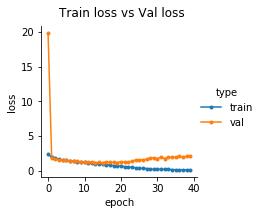

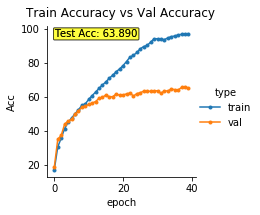

In [2]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1_1x1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2_3x3 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3_1x1 = nn.Conv2d(planes, 4*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(4*planes)
        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != 4*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, 4*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(4*planes)
            )


    def forward(self, x):
        out = self.relu(self.bn1(self.conv1_1x1(x)))
        out = self.relu(self.bn2(self.conv2_3x3(out)))
        out = self.bn3(self.conv3_1x1(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# resnet-152
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.inplanes = 64
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # for cifar-10
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.residual_block(64, 3, stride=1)
        #self.layer1 = self.residual_block(64, 1, stride=1)
        self.layer2 = self.residual_block(128, 8, stride=2)
        #self.layer2 = self.residual_block(128, 2, stride=2)
        self.layer3 = self.residual_block(256, 36, stride=2)
        #self.layer3 = self.residual_block(256, 4, stride=2)
        self.layer4 = self.residual_block(512, 3, stride=2)
        #self.layer4 = self.residual_block(512, 1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 10)


    def residual_block(self, planes, blocks, stride=1):
        layers = []
        layers.append(Bottleneck(self.inplanes , planes, stride))
        self.inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
#models = ['CNN', 'Resnet']
args.model = 'Resnet'
args.act = 'relu'
args.l2 = 0.00001
args.optim = 'SGD'  # 'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 1e-3
args.epoch = 40

args.train_batch_size = 256
args.test_batch_size = 64


print(args)
setting, result = experiment(partition, deepcopy(args))
plot_loss_variation(result)
plot_acc_variation(result)

### 3.4 Going deeper: More case studies
### 3.4.7 DenseNet
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide86.PNG?raw=true)

    g
***

### 3.4 Going deeper: More case studies
### 3.4.7 Sqeeze-and-excitation networks
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide87.PNG?raw=true)

    g
***

### 3.4 Going deeper: More Case studies
### 3.4.7 State-of-the-art
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide89.PNG?raw=true)

    g
***

### 3.4 Going deeper: More Case studies
### 3.4.7 State-of-the-art
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide89.PNG?raw=true)

    g
***